In [5]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt
import csv
import pickle

In [ ]:
# ################## THE BELOW CODE IS FOR READING THE MNIST DATA AND SAVING IT TO A CSV FILE, IT IS TO BE RUN ONLY ONCE ###################

# def load_mnist_images(filename):
#     with open(filename, 'rb') as f:
#         magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
#         images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
#     return images

# def load_mnist_labels(filename):
#     with open(filename, 'rb') as f:
#         magic, num_labels = struct.unpack(">II", f.read(8))
#         labels = np.frombuffer(f.read(), dtype=np.uint8)
#     return labels

# train_image_file = 'train-images.idx3-ubyte'
# train_label_file = 'train-labels.idx1-ubyte'
# test_image_file = 't10k-images.idx3-ubyte'
# test_label_file = 't10k-labels.idx1-ubyte'

# # Load training data
# train_images = load_mnist_images(train_image_file)
# train_labels = load_mnist_labels(train_label_file)
# flattened_train_images = train_images.reshape(train_images.shape[0], -1) 
# train_data = np.column_stack((train_labels, flattened_train_images)) 

# # Load test data
# test_images = load_mnist_images(test_image_file)
# test_labels = load_mnist_labels(test_label_file)
# flattened_test_images = test_images.reshape(test_images.shape[0], -1)  
# test_data = np.column_stack((test_labels, flattened_test_images)) 

# # Combine train and test data
# combined_data = np.vstack((train_data, test_data))

# # Save to CSV file
# csv_file = 'sec_b_data.csv'
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     header = ['label'] + [f'pixel{i+1}' for i in range(flattened_train_images.shape[1])]
#     writer.writerow(header)
#     writer.writerows(combined_data)

# print(f"Data saved to {csv_file}")

Data saved to sec_b_data.csv


In [7]:
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv('sec_b_data.csv')
X = df.drop('label', axis=1)
X = X / 255.0  # normalize the data
y = df['label']

def one_hot_encode(labels, num_classes):
    """Convert label indices to one-hot encoded format"""
    one_hot = np.zeros((len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

# Print original data shapes
print("Original data shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Perform 80:10:10 split
num_samples = X.shape[0]
train_index = int(0.8 * num_samples)
val_index = int(0.9 * num_samples)

X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_val = X.iloc[train_index:val_index]
y_val = y.iloc[train_index:val_index]

X_test = X.iloc[val_index:]
y_test = y.iloc[val_index:]

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#print the shapes of the data
print("Train data shapes:")
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)

print("Validation data shapes:")
print("X shape:", X_val.shape)
print("y shape:", y_val.shape)

print("Test data shapes:")
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)

num_classes = 10

y_train_encoded = one_hot_encode(y_train, num_classes)
y_val_encoded = one_hot_encode(y_val, num_classes)
y_test_encoded = one_hot_encode(y_test, num_classes)

Original data shapes:
X shape: (70000, 784)
y shape: (70000,)
Train data shapes:
X shape: (56000, 784)
y shape: (56000,)
Validation data shapes:
X shape: (7000, 784)
y shape: (7000,)
Test data shapes:
X shape: (7000, 784)
y shape: (7000,)


In [8]:
import numpy as np

def sigmoid(x, propagation_dir):
    if propagation_dir == "forward":
        x = np.clip(x, -500, 500)  # Limits x to avoid overflow
        return 1 / (1 + np.exp(-x))
    elif propagation_dir == "backward":
        sig = sigmoid(x, "forward")
        return sig * (1 - sig)

def tanh(x, propagation_dir):
    if propagation_dir == "forward":
        return np.tanh(x)
    elif propagation_dir == "backward":
        return 1 - np.tanh(x) ** 2

def relu(x, propagation_dir):
    if propagation_dir == "forward":
        return np.maximum(0, x)
    elif propagation_dir == "backward":
        return np.where(x > 0, 1, 0)

def leaky_relu(x, propagation_dir):
    if propagation_dir == "forward":
        return np.where(x > 0, x, 0.001 * x)
    elif propagation_dir == "backward":
        return np.where(x > 0, 1, 0.001)

def softmax(x, propagation_dir):
    if propagation_dir == "forward":
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

class NeuralNetwork:
    def __init__(self, N, A, lr, activation_function, weight_init_function, epochs, batch_size):
        self.N = N
        self.A = A
        self.lr = lr
        self.activation_function = activation_function
        self.weight_init_function = weight_init_function
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = self.initialize_weights()

    def initialize_weights(self):
        weights = []
        for i in range(1, self.N):
            weight_matrix = self.weight_init_function(self.A[i-1], self.A[i])
            weights.append(weight_matrix)
        return weights
    
    def fit(self, X, Y, X_val, Y_val, patience=5):
        train_losses = []  
        val_losses = []   
        best_val_loss = float('inf')
        patience_counter = 0  # To count epochs since the last improvement
        for epoch in range(self.epochs):
            train_loss = 0
            val_loss = 0
            for i in range(0, len(X), self.batch_size): 
                X_batch = X[i:i+self.batch_size]
                Y_batch = Y[i:i+self.batch_size]

                # Forward propagation
                activations = [X_batch]
                for j in range(len(self.weights) - 1):
                    z = np.dot(activations[-1], self.weights[j])
                    activations.append(self.activation_function(z, "forward"))
                z_final = np.dot(activations[-1], self.weights[-1])
                final_output = softmax(z_final, "forward")
                activations.append(final_output)
                
                # Backward propagation
                delta = final_output - Y_batch  # Gradient of softmax with cross entropy
                for j in range(len(self.weights) - 1, -1, -1):
                    grad_weights = np.dot(activations[j].T, delta) / len(Y_batch) 
                    if j > 0:
                        z = np.dot(activations[j-1], self.weights[j-1])  
                        delta = np.dot(delta, self.weights[j].T) * self.activation_function(z, "backward")
                    self.weights[j] -= self.lr * grad_weights         

            # Calculate training and validation losses
            final_output = self.predict_proba(X)
            train_loss = -np.mean(np.sum(Y * np.log(final_output + 1e-9), axis=1))
            train_losses.append(train_loss)
            
            final_output = self.predict_proba(X_val)
            val_loss = -np.mean(np.sum(Y_val * np.log(final_output + 1e-9), axis=1))
            val_losses.append(val_loss)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
            print(f'Epoch {epoch+1}/{self.epochs} -> Training Loss: {train_loss}, Validation Loss: {val_loss}')

        return train_losses, val_losses

    def predict_proba(self, X):
        activations = X
        for i, weight in enumerate(self.weights[:-1]):
            z = np.dot(activations, weight)
            activations = self.activation_function(z, "forward")
        z_final = np.dot(activations, self.weights[-1])
        return softmax(z_final, "forward")

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == np.argmax(y, axis=1))
    
# Weight initialization functions
np.random.seed(42)
def zero_init(in_dim, out_dim):
    # scale = 0.01
    # return np.random.uniform(-scale, scale, (in_dim, out_dim))
    return np.zeros((in_dim, out_dim))

def random_init(in_dim, out_dim, scale=0.1):
    return np.random.uniform(-scale, scale, (in_dim, out_dim))

def normal_init(in_dim, out_dim):
    return np.random.normal(0, 1.0 * np.sqrt(2 / in_dim), (in_dim, out_dim))

# Training setup
A = [784, 256, 128, 64, 32, 10] # 784 is number of ppixels and 10 is number of classes, the hidden layers is according to the question
epochs = 200
batch_size = 128
learning_rate = 1e-1 #0.1
activation_functions = [sigmoid, tanh, relu, leaky_relu]
weight_initializations = [zero_init, random_init, normal_init]

training_losses = {}
validation_losses = {}

# Training loop
for activation in activation_functions:
    for weight_init in weight_initializations:
        print(f'Training model with {activation.__name__} activation and {weight_init.__name__} weight initialization')        
        nn = NeuralNetwork(
            N=len(A),
            A=A,
            lr=learning_rate,
            activation_function=activation,
            weight_init_function=weight_init,
            epochs=epochs,
            batch_size=batch_size
        )
        train_losses = []
        val_losses = []
        train_losses, val_losses = nn.fit(X_train, y_train_encoded, X_val, y_val_encoded)

        model_key = f'{activation.__name__}_{weight_init.__name__}'
        with open(f'model_{model_key}.pkl', 'wb') as f:
            pickle.dump(nn, f)
        test_accuracy = nn.score(X_test, y_test_encoded)
        val_accuracy = nn.score(X_val, y_val_encoded)

        print(f'Activation: {activation.__name__}, Init: {weight_init.__name__}')
        print(f'Final Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')
        print(f'Val accuracy: {val_accuracy:.4f}')
        print(f'Test accuracy: {test_accuracy:.4f}\n')

        training_losses[model_key] = train_losses
        validation_losses[model_key] = val_losses

Training model with sigmoid activation and zero_init weight initialization
Epoch 1/200 -> Training Loss: 2.3027733046661236, Validation Loss: 2.302237479027332
Epoch 2/200 -> Training Loss: 2.302740745437175, Validation Loss: 2.302210321570546
Epoch 3/200 -> Training Loss: 2.302708731452819, Validation Loss: 2.3021839034083973
Epoch 4/200 -> Training Loss: 2.302677257334393, Validation Loss: 2.302158208117976
Epoch 5/200 -> Training Loss: 2.3026463181516363, Validation Loss: 2.3021332198213336
Epoch 6/200 -> Training Loss: 2.302615909313586, Validation Loss: 2.3021089230930714
Epoch 7/200 -> Training Loss: 2.3025860264680627, Validation Loss: 2.302085302876205
Epoch 8/200 -> Training Loss: 2.3025566654100706, Validation Loss: 2.3020623444067527
Epoch 9/200 -> Training Loss: 2.302527821999366, Validation Loss: 2.302040033147391
Epoch 10/200 -> Training Loss: 2.302499492087324, Validation Loss: 2.302018354730303
Epoch 11/200 -> Training Loss: 2.302471671453129, Validation Loss: 2.3019972

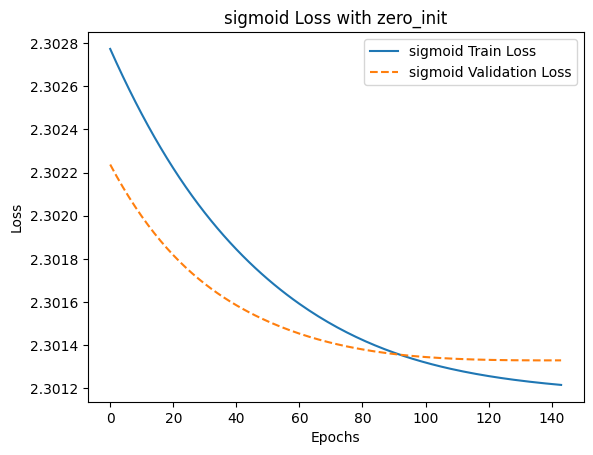

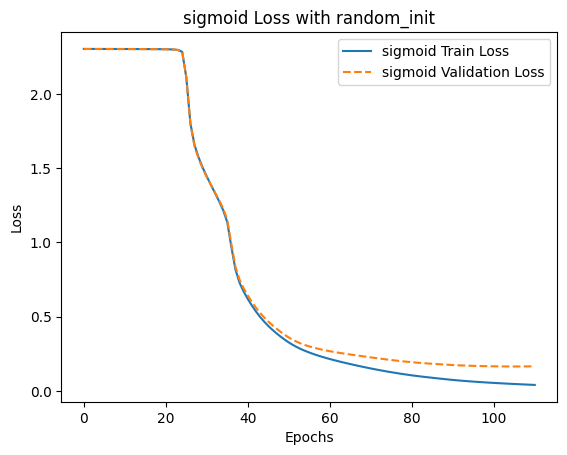

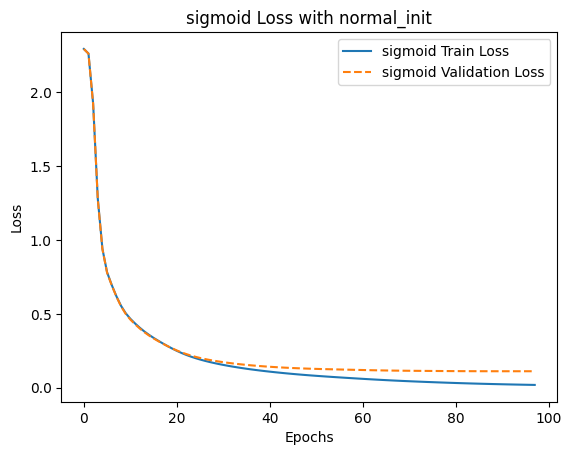

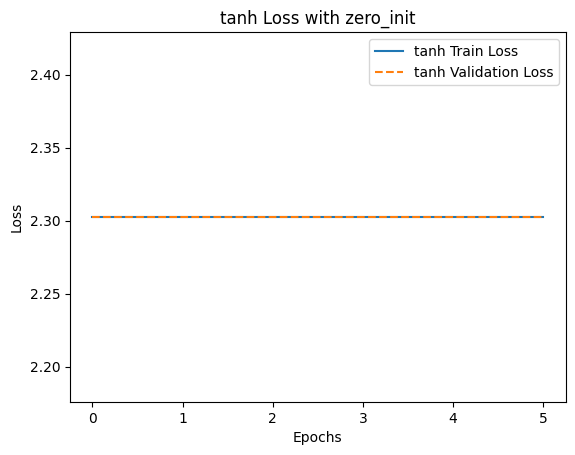

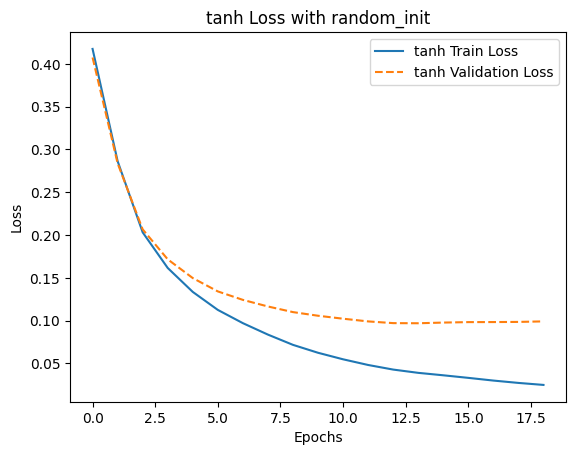

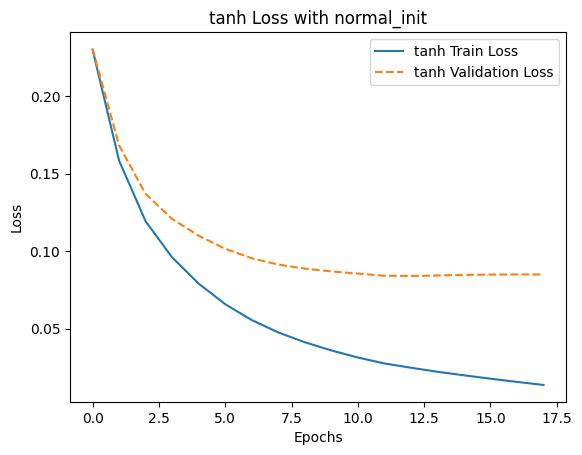

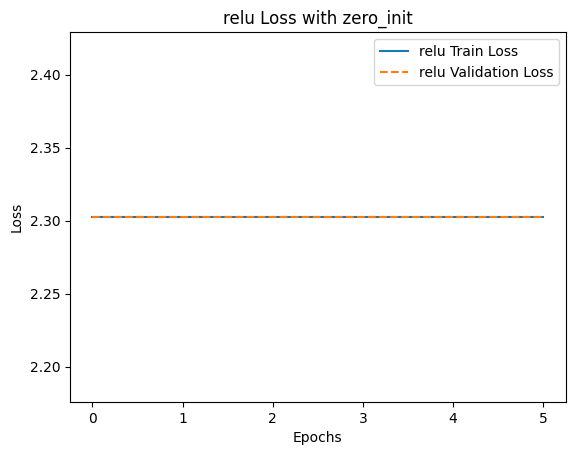

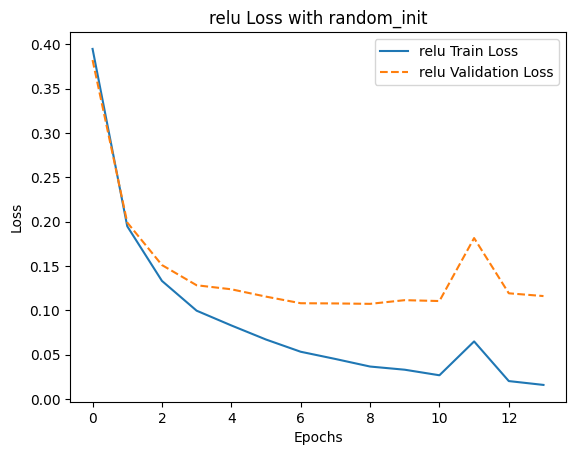

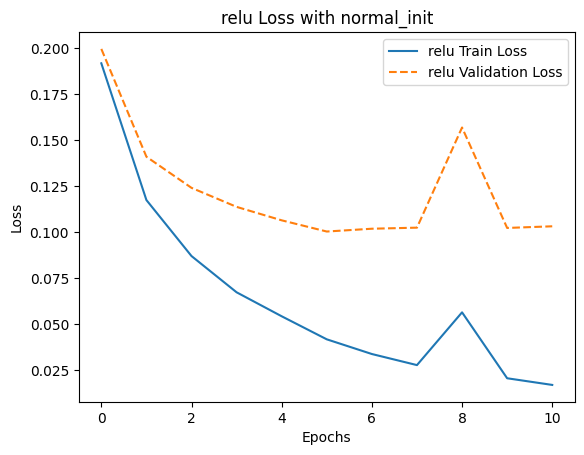

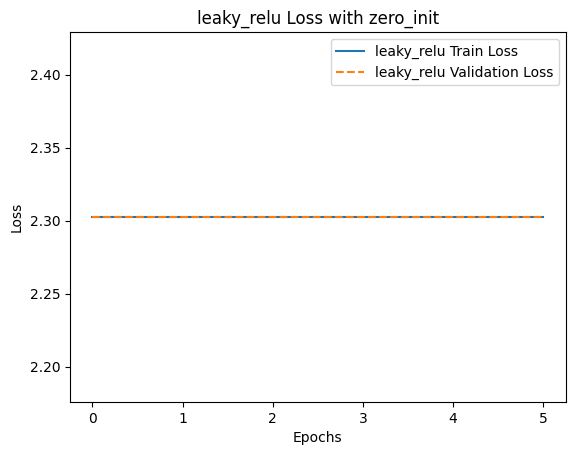

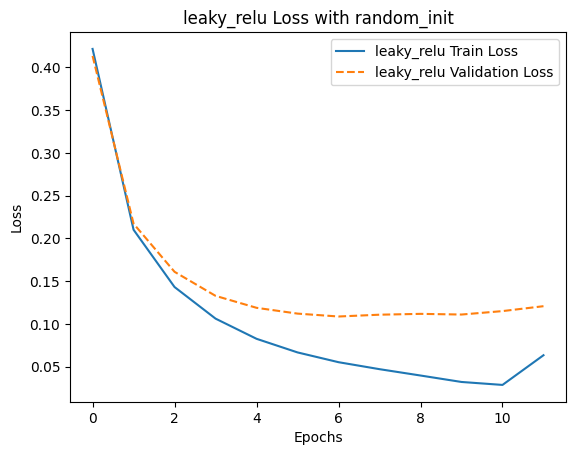

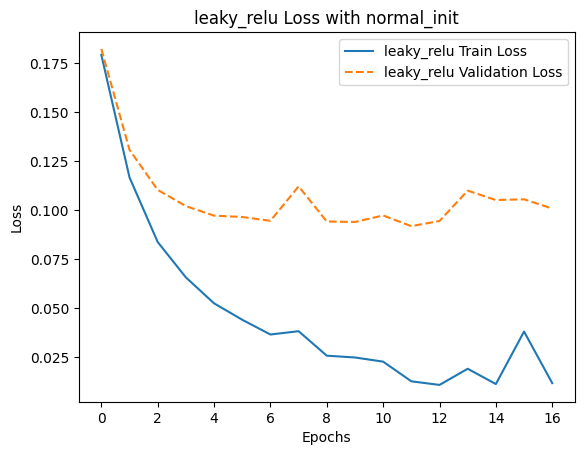

In [9]:
for activation in activation_functions:
    for weight_init in weight_initializations:
        model_key = f'{activation.__name__}_{weight_init.__name__}' 
        if model_key in training_losses and model_key in validation_losses:
            plt.plot(training_losses[model_key], label=f'{activation.__name__} Train Loss')
            plt.plot(validation_losses[model_key], label=f'{activation.__name__} Validation Loss', linestyle='dashed')
            plt.title(f'{activation.__name__} Loss with {weight_init.__name__}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

Original data shapes:
X shape: (70000, 784)
y shape: (70000,)
Train data shapes:
X shape: (56000, 784)
y shape: (56000,)
Validation data shapes:
X shape: (7000, 784)
y shape: (7000,)
Test data shapes:
X shape: (7000, 784)
y shape: (7000,)
Activation: sigmoid, Init: zero_init
Test accuracy: 0.1136

Activation: sigmoid, Init: random_init
Test accuracy: 0.9690

Activation: sigmoid, Init: normal_init
Test accuracy: 0.9750

Activation: tanh, Init: zero_init
Test accuracy: 0.1013

Activation: tanh, Init: random_init
Test accuracy: 0.9794

Activation: tanh, Init: normal_init
Test accuracy: 0.9821

Activation: relu, Init: zero_init
Test accuracy: 0.1013

Activation: relu, Init: random_init
Test accuracy: 0.9790

Activation: relu, Init: normal_init
Test accuracy: 0.9784

Activation: leaky_relu, Init: zero_init
Test accuracy: 0.1013

Activation: leaky_relu, Init: random_init
Test accuracy: 0.9713

Activation: leaky_relu, Init: normal_init
Test accuracy: 0.9833



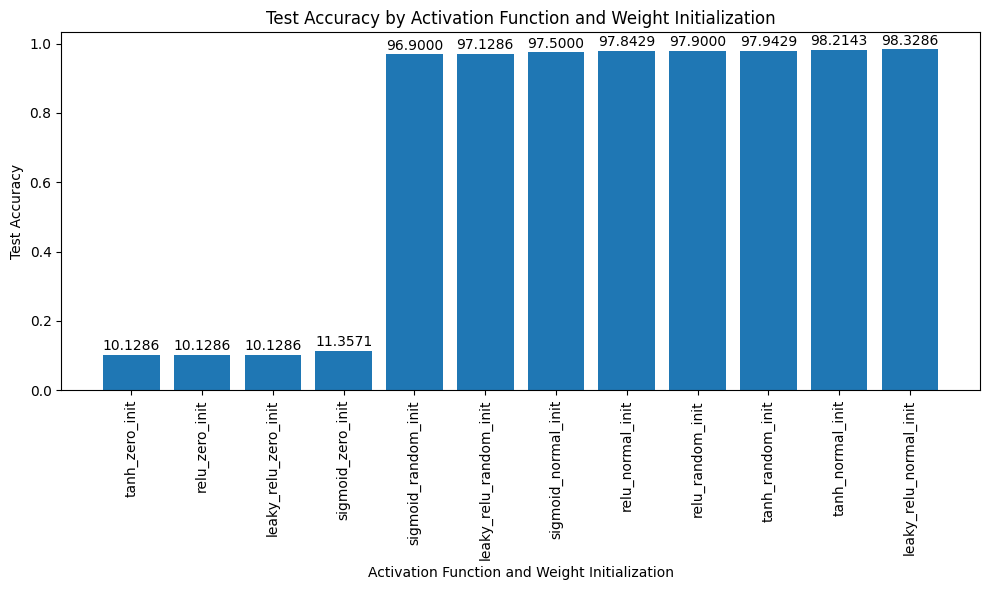

In [12]:
import pandas as pd
import numpy as np

# Load and preprocess data
df = pd.read_csv('sec_b_data.csv')
X = df.drop('label', axis=1)
X = X / 255.0  # normalize the data
y = df['label']

def one_hot_encode(labels, num_classes):
    """Convert label indices to one-hot encoded format"""
    one_hot = np.zeros((len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

# Print original data shapes
print("Original data shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Perform 80:10:10 split
num_samples = X.shape[0]
train_index = int(0.8 * num_samples)
val_index = int(0.9 * num_samples)

X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_val = X.iloc[train_index:val_index]
y_val = y.iloc[train_index:val_index]

X_test = X.iloc[val_index:]
y_test = y.iloc[val_index:]

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#print the shapes of the data
print("Train data shapes:")
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)

print("Validation data shapes:")
print("X shape:", X_val.shape)
print("y shape:", y_val.shape)

print("Test data shapes:")
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)

num_classes = 10

y_train_encoded = one_hot_encode(y_train, num_classes)
y_val_encoded = one_hot_encode(y_val, num_classes)
y_test_encoded = one_hot_encode(y_test, num_classes)

#reproducing the results for test set by loading the different models
data = {}
for activation in activation_functions:
    for weight_init in weight_initializations:
        with open(f'model_{activation.__name__}_{weight_init.__name__}.pkl', 'rb') as f:
            key = f"{activation.__name__}_{weight_init.__name__}"
            nn = pickle.load(f)
            test_accuracy = nn.score(X_test, y_test_encoded)
            print(f'Activation: {activation.__name__}, Init: {weight_init.__name__}')
            print(f'Test accuracy: {test_accuracy:.4f}\n')
            data[key] = test_accuracy

sorted_data = sorted(data.items(), key=lambda x: x[1])
labels, accuracies = zip(*sorted_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(labels)), accuracies)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_title("Test Accuracy by Activation Function and Weight Initialization")
ax.set_xlabel("Activation Function and Weight Initialization")
ax.set_ylabel("Test Accuracy")
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.005, f'{v*100:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()